 # NLP FINAL PROJECT <br> Investigating relationships between movie dialogue and movie genre

## Data Prep

In [1]:
import pandas as pd
import numpy as np
import re
import itertools
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from stop_words import get_stop_words
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Read in the data
with open("data/movie_lines.txt", 'rb') as f:
     lines = [l.decode('utf8', 'ignore') for l in f.readlines()]
        
with open("data/movie_characters_metadata.txt", 'rb') as f:
     characters = [l.decode('utf8', 'ignore') for l in f.readlines()]
        
with open("data/movie_titles_metadata.txt", 'rb') as f:
     movies = [l.decode('utf8', 'ignore') for l in f.readlines()]

In [3]:
# Split lines on delimiter
lines = [l.split(' +++$+++ ') for l in lines]
characters = [l.split(' +++$+++ ') for l in characters]
movies = [l.split(' +++$+++ ') for l in movies]

In [4]:
# Create dataframe for lines data
lines_df = pd.DataFrame(lines)
lines_df.columns = ['line_ID', 'character_ID', 'movie_ID', 'character_name', 'line_text']

In [5]:
# Strip newline from line_text
lines_df['line_text'] = lines_df['line_text'].apply(lambda x: x.strip())

In [6]:
lines_df.head()

,line_ID,character_ID,movie_ID,character_name,line_text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [7]:
# Create dataframe for character data
char_df = pd.DataFrame(characters)
char_df.columns = ['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender', 'credit_pos']

In [8]:
char_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_pos
0,u0,BIANCA,m0,10 things i hate about you,f,4\n
1,u1,BRUCE,m0,10 things i hate about you,?,?\n
2,u2,CAMERON,m0,10 things i hate about you,m,3\n
3,u3,CHASTITY,m0,10 things i hate about you,?,?\n
4,u4,JOEY,m0,10 things i hate about you,m,6\n


In [9]:
movies_df = pd.DataFrame(movies)
movies_df.columns = ['movie_ID', 'movie_title', 'year', 'rating', 'num_votes', 'genre']

In [10]:
movies_df.head()

,movie_ID,movie_title,year,rating,num_votes,genre
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']\n"
1,m1,1492: conquest of paradise,1992,6.20,10421,"['adventure', 'biography', 'drama', 'history']\n"
2,m2,15 minutes,2001,6.10,25854,"['action', 'crime', 'drama', 'thriller']\n"
3,m3,2001: a space odyssey,1968,8.40,163227,"['adventure', 'mystery', 'sci-fi']\n"
4,m4,48 hrs.,1982,6.90,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


In [11]:
# Strip newline, brackets, and quotations from genre
movies_df['genre'] = movies_df['genre'].apply(lambda x: x.strip())
movies_df['genre'] = movies_df['genre'].apply(lambda x: x.strip('['))
movies_df['genre'] = movies_df['genre'].apply(lambda x: x.strip(']'))
movies_df['genre'] = movies_df['genre'].apply(lambda x: re.sub("[']", '', x))

In [12]:
# Turn genre column into a list
movies_df['genre'] = movies_df['genre'].apply(lambda x: x.split(','))
movies_df['genre'] = movies_df['genre'].apply(lambda x: [y.strip() for y in x])

In [13]:
movies_df.head()

,movie_ID,movie_title,year,rating,num_votes,genre
0,m0,10 things i hate about you,1999,6.90,62847,"[comedy, romance]"
1,m1,1492: conquest of paradise,1992,6.20,10421,"[adventure, biography, drama, history]"
2,m2,15 minutes,2001,6.10,25854,"[action, crime, drama, thriller]"
3,m3,2001: a space odyssey,1968,8.40,163227,"[adventure, mystery, sci-fi]"
4,m4,48 hrs.,1982,6.90,22289,"[action, comedy, crime, drama, thriller]"


In [14]:
# Join lines and characters dataframes
data = pd.merge(lines_df, char_df, how = 'left', on = ['movie_ID', 'character_ID'])
data = data.drop(['character_name_y'], axis = 1)
data = data.rename(index=str, columns={"character_name_x": "character_name"})

In [15]:
# Join movies data frame with merged dataframe
data = pd.merge(data, movies_df, how = 'left', on = 'movie_ID')
data = data.drop(['movie_title_y'], axis = 1)
data = data.rename(index=str, columns={"movie_title_x": "movie_title"})

In [16]:
data.head()

,line_ID,character_ID,movie_ID,character_name,line_text,movie_title,gender,credit_pos,year,rating,num_votes,genre
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,f,4\n,1999,6.90,62847,"[comedy, romance]"
1,L1044,u2,m0,CAMERON,They do to!,10 things i hate about you,m,3\n,1999,6.90,62847,"[comedy, romance]"
2,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,f,4\n,1999,6.90,62847,"[comedy, romance]"
3,L984,u2,m0,CAMERON,She okay?,10 things i hate about you,m,3\n,1999,6.90,62847,"[comedy, romance]"
4,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,f,4\n,1999,6.90,62847,"[comedy, romance]"


In [17]:
# Create one-hot encoding of genre
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
data = data.join(pd.DataFrame(mlb.fit_transform(data.pop('genre')),
                          columns=mlb.classes_,
                          index=data.index))

In [18]:
data.head()

,line_ID,character_ID,movie_ID,character_name,line_text,movie_title,gender,credit_pos,year,rating,...,music,musical,mystery,romance,sci-fi,short,sport,thriller,war,western
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,f,4\n,1999,6.90,...,0,0,0,1,0,0,0,0,0,0
1,L1044,u2,m0,CAMERON,They do to!,10 things i hate about you,m,3\n,1999,6.90,...,0,0,0,1,0,0,0,0,0,0
2,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,f,4\n,1999,6.90,...,0,0,0,1,0,0,0,0,0,0
3,L984,u2,m0,CAMERON,She okay?,10 things i hate about you,m,3\n,1999,6.90,...,0,0,0,1,0,0,0,0,0,0
4,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,f,4\n,1999,6.90,...,0,0,0,1,0,0,0,0,0,0


## EDA

In [19]:
# Separate out genres to investigate 
horror = data.loc[data['horror'] == 1]
adult = data.loc[data['adult'] == 1]

In [20]:
# Create corpus for each genre
horror_lines = list(horror.line_text)
horror_corpus = [line.split() for line in horror_lines]
horror_corpus = list(itertools.chain.from_iterable(horror_corpus))
horror_corpus = [re.sub("[.?!,-]", '', word) for word in horror_corpus]

adult_lines = list(adult.line_text)
adult_corpus = [line.split() for line in adult_lines]
adult_corpus = list(itertools.chain.from_iterable(adult_corpus))
adult_corpus = [re.sub("[.?!,-]", '', word) for word in adult_corpus]

In [21]:
# Define a function to split contractions
def split_contractions(word):
    word = re.sub(r"won't", "will not", word)
    word = re.sub(r"can\'t", "can not", word)
    word = re.sub(r"n\'t", " not", word)
    word = re.sub(r"\'re", " are", word)
    word = re.sub(r"\'s", " is", word)
    word = re.sub(r"\'d", " would", word)
    word = re.sub(r"\'ll", " will", word)
    word = re.sub(r"\'t", " not", word)
    word = re.sub(r"\'ve", " have", word)
    word = re.sub(r"\'m", " am", word)
    return word

In [22]:
# Apply split contractions function to each corpus and reformat corpus into proper bag-of-words format
horror_corpus = [split_contractions(word) for word in horror_corpus]
horror_corpus = [line.split(" ") for line in horror_corpus]
horror_corpus = list(itertools.chain.from_iterable(horror_corpus))

adult_corpus = [split_contractions(word) for word in adult_corpus]
adult_corpus = [line.split(" ") for line in adult_corpus]
adult_corpus = list(itertools.chain.from_iterable(adult_corpus))

In [23]:
# Make all words lowercase
horror_corpus = [word.lower() for word in horror_corpus]
adult_corpus = [word.lower() for word in adult_corpus]

In [24]:
# Remove stop words from each corpus
en_stop = get_stop_words('en')
horror_corpus = [word for word in horror_corpus if not word in en_stop]
adult_corpus = [word for word in adult_corpus if not word in en_stop]

In [25]:
# Get word counts for words in each corpus
from collections import Counter
horror_word_count = Counter(horror_corpus)
adult_word_count = Counter(adult_corpus)

In [26]:
# Delete empty string key from dictionaries
del horror_word_count[""]
del adult_word_count[""]

In [27]:
# Sort the word count dictionaries
import operator
horror_word_counts_sorted = sorted(horror_word_count.items(), key=operator.itemgetter(1), reverse = True)
adult_word_counts_sorted = sorted(adult_word_count.items(), key=operator.itemgetter(1), reverse = True)

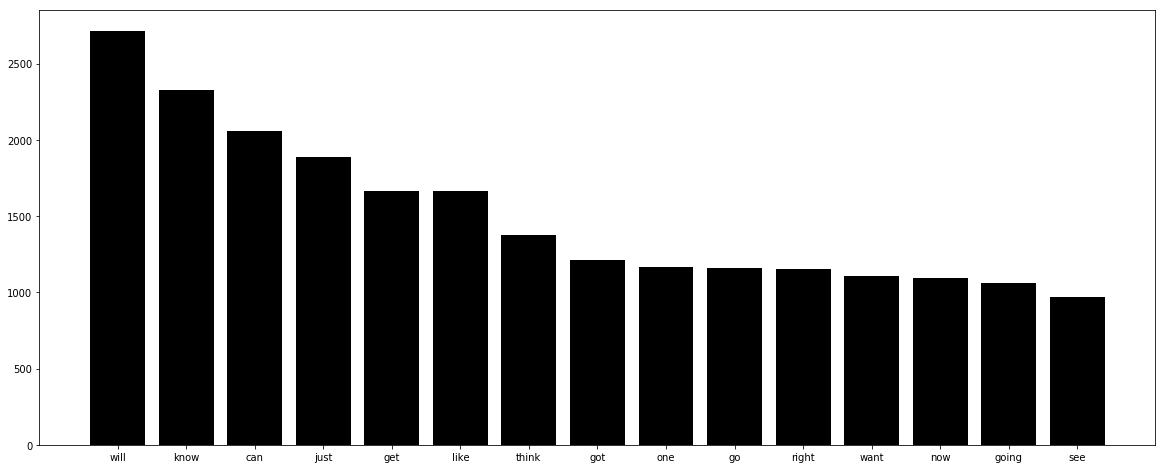

In [28]:
# Plot most frequent words
sample = horror_word_counts_sorted[:15]
labels, values = zip(*sample)
plt.figure(figsize=(20,8))
plt.bar(labels, values, align='center', color = 'black')
plt.show();

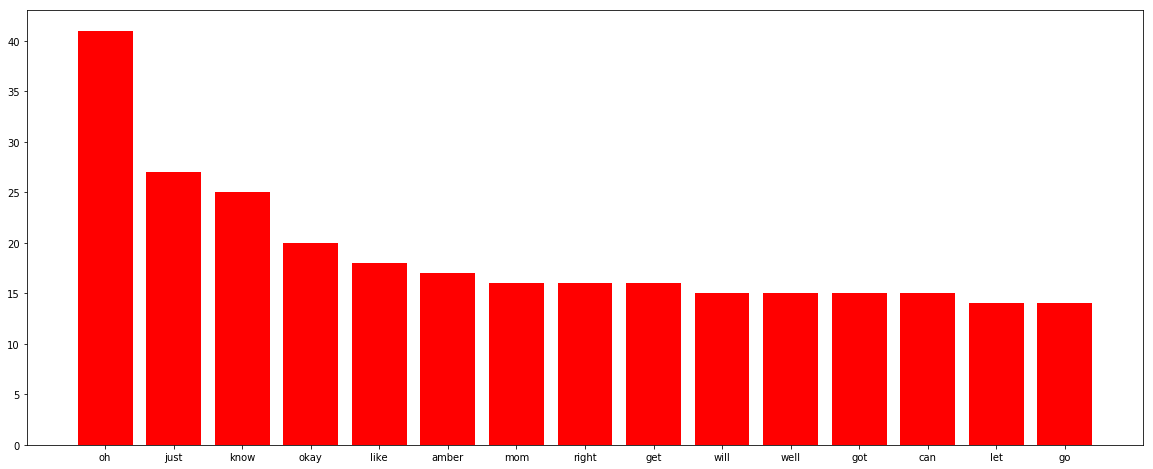

In [29]:
# Plot most frequent words
sample = adult_word_counts_sorted[:15]
labels, values = zip(*sample)
plt.figure(figsize=(20,8))
plt.bar(labels, values, align='center', color = 'red')
plt.show();

## Sentiment Analysis

In [30]:
# Get sentiment score for dialogue
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [31]:
# Create function to bin sentiments scores into positive, negative, or neutral
def label_pos_neg_neutral(score):
    if score < 0:
        return 'neg'
    elif score > 0:
        return 'pos'
    else: 
        return 'neut'

In [32]:
# Apply score classification function to selected genre dataframes
horror['sentiment'] = horror['line_text'].apply(lambda x: analyser.polarity_scores(x)['compound']) # get sentiment
horror['sentiment_class'] = horror['sentiment'].apply(label_pos_neg_neutral) # classify sentiment

adult['sentiment'] = adult['line_text'].apply(lambda x: analyser.polarity_scores(x)['compound']) # get sentiment
adult['sentiment_class'] = adult['sentiment'].apply(label_pos_neg_neutral) # classify sentiment

war = data.loc[data.war == 1]
war['sentiment'] = war['line_text'].apply(lambda x: analyser.polarity_scores(x)['compound']) # get sentiment
war['sentiment_class'] = war['sentiment'].apply(label_pos_neg_neutral) # classify sentiment

comedy = data.loc[data.comedy == 1]
comedy['sentiment'] = comedy['line_text'].apply(lambda x: analyser.polarity_scores(x)['compound']) # get sentiment
comedy['sentiment_class'] = comedy['sentiment'].apply(label_pos_neg_neutral) # classify sentiment

In [33]:
# Calculate the count of each sentiment classification for each genre
horror_pos = horror.loc[horror.sentiment_class == 'pos'].shape[0]
horror_neg = horror.loc[horror.sentiment_class == 'neg'].shape[0]
horror_neut = horror.loc[horror.sentiment_class == 'neut'].shape[0]

adult_pos = adult.loc[adult.sentiment_class == 'pos'].shape[0]
adult_neg = adult.loc[adult.sentiment_class == 'neg'].shape[0]
adult_neut = adult.loc[adult.sentiment_class == 'neut'].shape[0]

war_pos = war.loc[war.sentiment_class == 'pos'].shape[0]
war_neg = war.loc[war.sentiment_class == 'neg'].shape[0]
war_neut = war.loc[war.sentiment_class == 'neut'].shape[0]

comedy_pos = comedy.loc[comedy.sentiment_class == 'pos'].shape[0]
comedy_neg = comedy.loc[comedy.sentiment_class == 'neg'].shape[0]
comedy_neut = comedy.loc[comedy.sentiment_class == 'neut'].shape[0]

In [34]:
# Create dataframes of class counts
horror_class = pd.DataFrame([['negative', 'neutral', 'positive'], [horror_neg, horror_neut, horror_pos]]).transpose()
horror_class.columns = ['sentiment', 'count']

adult_class = pd.DataFrame([['negative', 'neutral', 'positive'], [adult_neg, adult_neut, adult_pos]]).transpose()
adult_class.columns = ['sentiment', 'count']

war_class = pd.DataFrame([['negative', 'neutral', 'positive'], [war_neg, war_neut, war_pos]]).transpose()
war_class.columns = ['sentiment', 'count']

comedy_class = pd.DataFrame([['negative', 'neutral', 'positive'], [comedy_neg, comedy_neut, comedy_pos]]).transpose()
comedy_class.columns = ['sentiment', 'count']

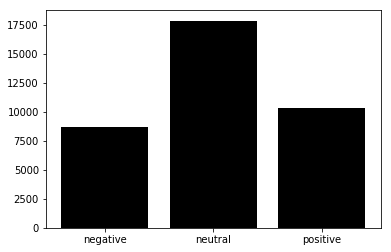

In [80]:
# Plot sentiment data
plt.bar(horror_class['sentiment'], horror_class['count'], color = 'black')
plt.show();

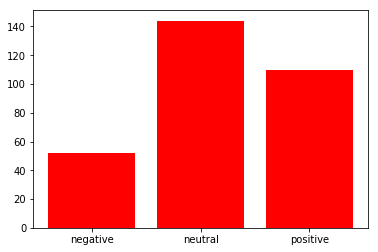

In [79]:
# Plot sentiment data
plt.bar(adult_class['sentiment'], adult_class['count'], color = 'red')
plt.show();

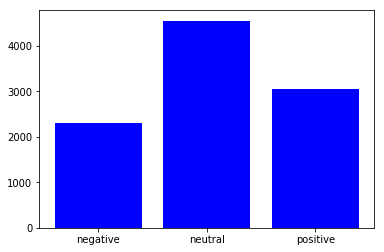

In [78]:
# Plot sentiment data
plt.bar(war_class['sentiment'], war_class['count'], color = 'blue')
plt.show();

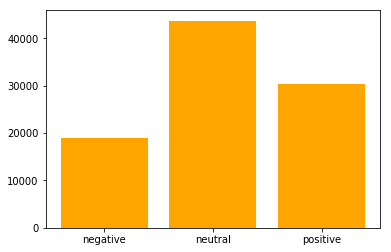

In [77]:
# Plot sentiment data
plt.bar(comedy_class['sentiment'], comedy_class['count'], color = 'orange')
plt.show();

## Modeling -- Predicting genres using dialogue text

In [39]:
# Want to only look at top 10 genres
counts = []
genres = ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi',
       'short', 'sport', 'thriller', 'war', 'western']
for genre in genres:
    counts.append((sum(data[genre]), genre))
sorted(counts, reverse = True)[0:10]

[(172557, 'drama'),
 (122256, 'thriller'),
 (93248, 'comedy'),
 (77518, 'romance'),
 (74859, 'crime'),
 (66128, 'action'),
 (50378, 'mystery'),
 (44535, 'sci-fi'),
 (43216, 'adventure'),
 (36879, 'horror')]

In [40]:
# Creat CountVectorizer and Tfidf Transformer to be used for text feature engineering
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

### Action

In [131]:
# Create training data for text classification model
X = data['line_text']
y = data['action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [132]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [133]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.80270088443299481

In [134]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [135]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.79943553812578971

### Adventure

In [87]:
# Create training data for text classification model
X = data['line_text']
y = data['adventure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [88]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [89]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.86882824934775116

In [90]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [91]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.86574339957009006

### Comedy

In [92]:
# Create training data for text classification model
X = data['line_text']
y = data['comedy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [93]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [94]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.72713847365571105

In [95]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [96]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.71978734227064634

### Crime

In [97]:
# Create training data for text classification model
from sklearn.model_selection import train_test_split
X = data['line_text']
y = data['crime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [98]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [99]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.78094284823523619

In [100]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [101]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.77219697094005879

### Drama

In [102]:
# Create training data for text classification model
X = data['line_text']
y = data['drama']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [103]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [104]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.64524227556897429

In [105]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [106]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.6424691925241619

### Horror

In [107]:
# Create training data for text classification model
X = data['line_text']
y = data['horror']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [108]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [109]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.88367819109659851

In [110]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [111]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.88138096253876574

### Mystery

In [112]:
# Create training data for text classification model
X = data['line_text']
y = data['mystery']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [113]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [114]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.84449403541013734

In [115]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [58]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.84180299624239041

### Romance

In [116]:
# Create training data for text classification model
X = data['line_text']
y = data['romance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [117]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [118]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.76525605894032134

In [119]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [120]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.760333426316394

### Sci-fi

In [121]:
# Create training data for text classification model
X = data['line_text']
y = data['sci-fi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [122]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [123]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.86887747567399043

In [124]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [125]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.86539881528641516

### Thriller

In [126]:
# Create training data for text classification model
X = data['line_text']
y = data['thriller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [127]:
# Fit model using CountVectorizer alone
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [128]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.66096188241471543

In [129]:
# Fit model using CountVectorizer and TfidfTranformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()) ])
text_clf = text_clf.fit(X_train, y_train)

In [130]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.65702377631557352

## Summary

* Use of CountVectorizer alone slightly outperforms CountVectorizer + TfidfTransformer for all genres
* The genre with the highest predictive accuracy is Horror
* The genre with the lowest predictive accuracy is Drama